# sport-adverse-events

## init code

In [135]:
import io
import os
from glob import glob
import pandas as pd
from pathlib import Path
from pandas_plots import tbl, pls
from connection_helper import pgp
from dotenv import load_dotenv, find_dotenv
import missingno as mi
import re

os.environ["THEME"]="dark"

dir_data_in=Path("../data/in")
dir_data_out=Path("../data/out")

# ! only 1 csv file in in/ is allowed
file_csv_list=glob(f"{dir_data_in}/*.csv")
assert len(file_csv_list) == 1, f"❌ Expected 1 csv file, found {len(file_csv_list)}"

file_csv = file_csv_list[0]
file_xls=Path(dir_data_in/"Register_fertig.xlsx")

## (optional) decrypt data

In [136]:
# # * get .env file and expect KEY_PIN
# _path_env = find_dotenv()
# if _path_env:
#     load_dotenv(_path_env)
# _key_pin = os.getenv("KEY_PIN")

# encr_file_path=".local/RegisterZurErfassung_DATA_LABELS_2024-01-11_1301.csv.gpg"
# result=pgp.pgp_decrypt(message_file_path=encr_file_path,passphrase=_key_pin)

## load data
- ⚠️ strategy to import the csv raw data:
  - ❌ do not use default `pd.read_csv()`, its not as error tolerant as excel
  - ✅ read csv as `windows-1252` string and cleanse it
    - most (not all) lines have heading + trailing quotes, remove
    - data have a mixture of "" and ", downgrade by 1
    - delimiter "," also occurs in quotes, change to ";" only outside of quotes
    - now byte stream can be imported

In [137]:
#
# * replace delimiter *only* outside of quotes
def replace_delimiter_outside_quotes(
    input: str, delimiter_old: str = ",", delimiter_new: str = ";", quotechar: str = '"'
):
    outside_quotes = True
    output = ""
    # * loop through input and toggle inside/outside status
    for char in input:
        if char == quotechar:
            outside_quotes = not outside_quotes
        elif outside_quotes and char == delimiter_old:
            char = delimiter_new
        output += char
    return output

In [138]:
#
# * downgrades quotes in string to normalize quots: " -> NA, "" -> "
def reduce_quotes_in_string(input: str):
    output = ""
    len_=len(input)
    i = 0
    while i < len_:
        # * check current + next char if within range
        if input[i] == '"' and i+1 < len_ and input[i+1] != '"':
            output += ''
            i = i+1
        elif input[i] == '"'and i+1 < len_ and input[i+1] == '"':
            output+= '"'
            i = i+2
        else:
            output += input[i]
            i=i+1
    return output

In [139]:
#
# * read excel
df_xls=pd.read_excel(file_xls, sheet_name="Tabelle fertig")

# * read csv -> variable
with open(file_csv, encoding="windows-1252") as f:
    csv=f.read()

In [140]:
# * selectively change , into ;
csv_lines = csv.splitlines()
csv_lines_new = []
for line in csv_lines[:]:
    # * remove first and last quotes if present
    if line[:1] == '"':
        line = line[1:-1]
    # * tailor line by line
    line=reduce_quotes_in_string(line)
    line=replace_delimiter_outside_quotes(line)
    # * just now quotes can be removed, not before
    line=line.replace('"', '')
    csv_lines_new.append(line)
    # print(f'{line.count(";")} {line}')

# * list -> string fo feed into df constructor
csv_string = "\n".join(csv_lines_new).replace('\t', '')

df_csv = pd.read_csv(
    io.StringIO(csv_string),
    sep=";",
    encoding="windows-1252",
)


## arrange data

### set columns

In [141]:
# * prevent float conversion due to NA
df_csv['CTCAE-Bewertung'] = df_csv['CTCAE-Bewertung'].astype('Int64')
# * mix date values into on1, these are disjoint
df_csv['Datum'].fillna(df_csv['Survey Timestamp'], inplace=True)

### parse dates to datetime 🕥

In [142]:
# * manual override if needed
df_csv.loc[df_csv["Datum"]=="2023_08_2028","Datum"]="2023_08_28"

# * parse date col
REG_DATE_YYYY_MM=r"\d{4}_\d{2}$"
REG_DATE_YYYY_MM_DD=r"\d{4}_\d{2}_\d{2}$"

# * get all data from YYYY_MM
_df1=df_csv[df_csv["Datum"].str.contains(REG_DATE_YYYY_MM, na=False)]["Datum"]
_df2=df_csv[df_csv["Datum"].str.contains(REG_DATE_YYYY_MM_DD, na=False)]["Datum"]

# * convert to datetime
_df1=pd.to_datetime(_df1, format="%Y_%m")
_df2=pd.to_datetime(_df2, format="%Y_%m_%d")

# * update in place
df_csv.update(_df1)
df_csv.update(_df2)

# * now convert the whole col
df_csv["Datum"]=pd.to_datetime(df_csv["Datum"])

## reduce data

### (optional) remove columns w/ no or few values

In [143]:
# * remove columns with no value
cols_no_value = [col for col in df_csv.columns if df_csv[col].isna().all()]
display(df_csv[cols_no_value][:3])

# * show columns with few values
# _few_values_threshold = 3
# cols_few_values = [col for col in df_csv.columns if (df_csv[col].notna().sum() < _few_values_threshold and df_csv[col].notna().any())]
# df_csv[cols_few_values][:10]

# ! remove columns
cols_after_removal = list(set(df_csv.columns) - set(cols_no_value))
df_csv = df_csv[list(set(df_csv.columns) - set(cols_no_value))]
print(f"removing {len(df_csv.columns) - len(cols_after_removal)} columns.")

,Survey Identifier,Wie lange dauerte(n) die Konsequenz(en) an?,Wie lange dauerte(n) die Konsequenz(en) an?.2,Was genau?,Wie lange dauerte(n) die Konsequenz(en) an?.5,Survey Timestamp.1,An welchem NAOK-Standort ist das AE aufgetreten?.1,Erläuterung Sonstiges.1,Wie lange dauerte(n) die Konsequenz(en) an?.7,Das AE ist durch den Sport neu aufgetreten..1,...,Wie alt war der/die Betroffene zum Zeitpunkt des AE?.2,Fand das Sportprogramm-Online statt?.1,Fand das AE im Rahmen einer Sporttestung statt?.1,In welchem Setting ist das AE aufgetreten?.2,Erläuterung Sonstiges.5,Was ist genau passiert?.2,Erläuterung Sonstiges.6,In welcher Phase der geplanten Sporteinheit trat das AE auf?.2,"Glaubst Du, dass das AE mit dem Sport assoziiert ist?",Anmerkung.2
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


removing 0 columns.


### (optional) merge excel columns with csv columns

In [144]:
# * dont use set operations to maintain order
_len_before=len(df_csv.columns)
cols_csv_and_excel=[col for col in df_xls.columns if col in df_csv.columns]
# * append exceptions if desired
# cols_csv_and_excel.append("Survey Timestamp")

# ! reduce columns
df_csv = df_csv[cols_csv_and_excel]

print(f"merged csv columns ({_len_before}) with excel columns ({len(df_xls.columns)}) into ({len(df_csv.columns)})")

merged csv columns (147) with excel columns (69) into (40)


## show data

🔵 *** df: df_csv ***
🟣 shape: (50, 40) columns: ['Participant ID', 'Datum', 'CTCAE-Bewertung', 'Was war das AE? (Schmerz, Schürfwunde etc.)', 'Hat jemand mit Expertise  die Situation geprüft?', "Diese Person hat ein 'OK' zum Weitermachen gegeben.  ", 'Wurde etwas Strukturelles verändert?', 'Sind Schmerzen aufgetreten?', 'Wie stark waren diese Schmerzen?', 'Wie kommen Sie zu dieser Einschätzung?', 'Kam es zu einem Krankenhausaufenthalt oder einer Verlängerung eines solchen?', 'Kam es zu einer medizinischen Weiterbehandlung? ', 'Kam es zu einer deutlichen Verzögerung bei der Einhaltung des medizinischen Therapieprotokolls?', 'Kam es zu einem erhöhten Pflegebedarf', 'Kam es zum Verlust der Selbstständigkeit (bspw. Einschränkungen beim Baden, An- und Ausziehen, Selbsternährung, Toilettennutzung)?', 'In welchem Maße?', 'Wurde die PECH-Regel angewendet?', 'Wurde das Kind nach dem AE observiert?', 'Kam es zum Tod?', 'Fallen Ihnen weitere Konsequenzen ein?', 'Was ist genau passiert?', 'Wurde d

,Participant ID,Datum,CTCAE-Bewertung,"Was war das AE? (Schmerz, Schürfwunde etc.)",Hat jemand mit Expertise die Situation geprüft?,Diese Person hat ein 'OK' zum Weitermachen gegeben.,Wurde etwas Strukturelles verändert?,Sind Schmerzen aufgetreten?,Wie stark waren diese Schmerzen?,Wie kommen Sie zu dieser Einschätzung?,...,Wie alt war der/die Betroffene zum Zeitpunkt des AE?,Fand das Sportprogramm-Online statt?,Fand das AE im Rahmen einer Sporttestung statt?,In welchem Setting ist das AE aufgetreten?,Erläuterung Sonstiges,In welcher Phase der geplanten Sporteinheit trat das AE auf?,Anmerkung,An welchem NAOK-Standort ist das AE aufgetreten?,Wie viele Sporteinheiten finden ca. jährlich am Standort statt?,Complete?
0,1,NaT,<NA>,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,NaN,Incomplete
1,2,2022-10-13 12:26:32,1,Schürfwunde an der Wange,nan,Ja,No,nan,nan,nan,...,6 bis 9 Jahre,No,No,Sonstiges,Kletterwand in Turnhalle,1. Hälfe,nan,Essen,NaN,Complete
2,3,2022-10-13 13:41:16,2,strake Übelkeit,nan,nan,No,Ja,stark,Einschätzung von außen durch Sporttherapeutin,...,10 bis 14 Jahre,No,No,Sonstiges,Spielzimmer Klinik,2. Hälfte,nan,Essen,NaN,Complete


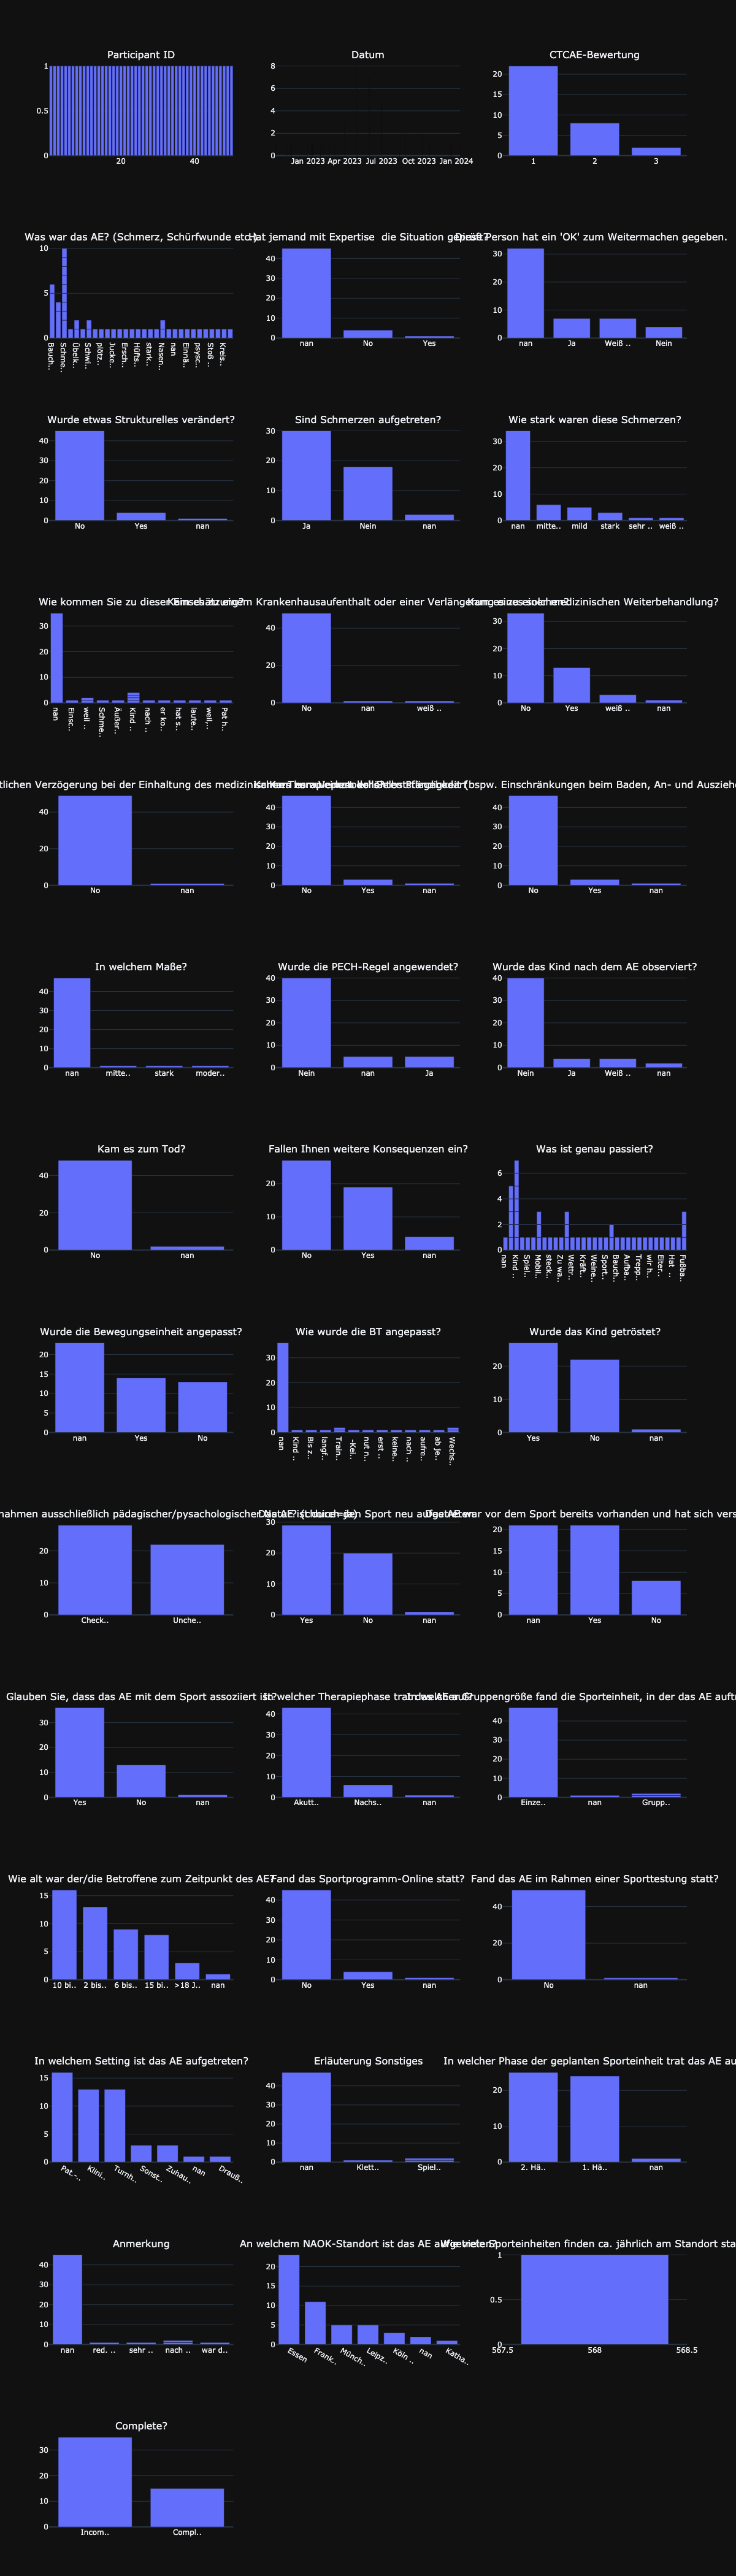

In [145]:
tbl.describe_df(df_csv.iloc[:,:], "df_csv", top_n_uniques=5, top_n_chars_in_index=5, use_plot=True)

## 💾 data for pivot use

In [146]:
df_csv.reset_index().to_csv(Path(dir_data_out/"df_csv.csv"),sep=";", index=False, encoding="utf-8-sig")

## analysis showcase 📈

<Axes: >

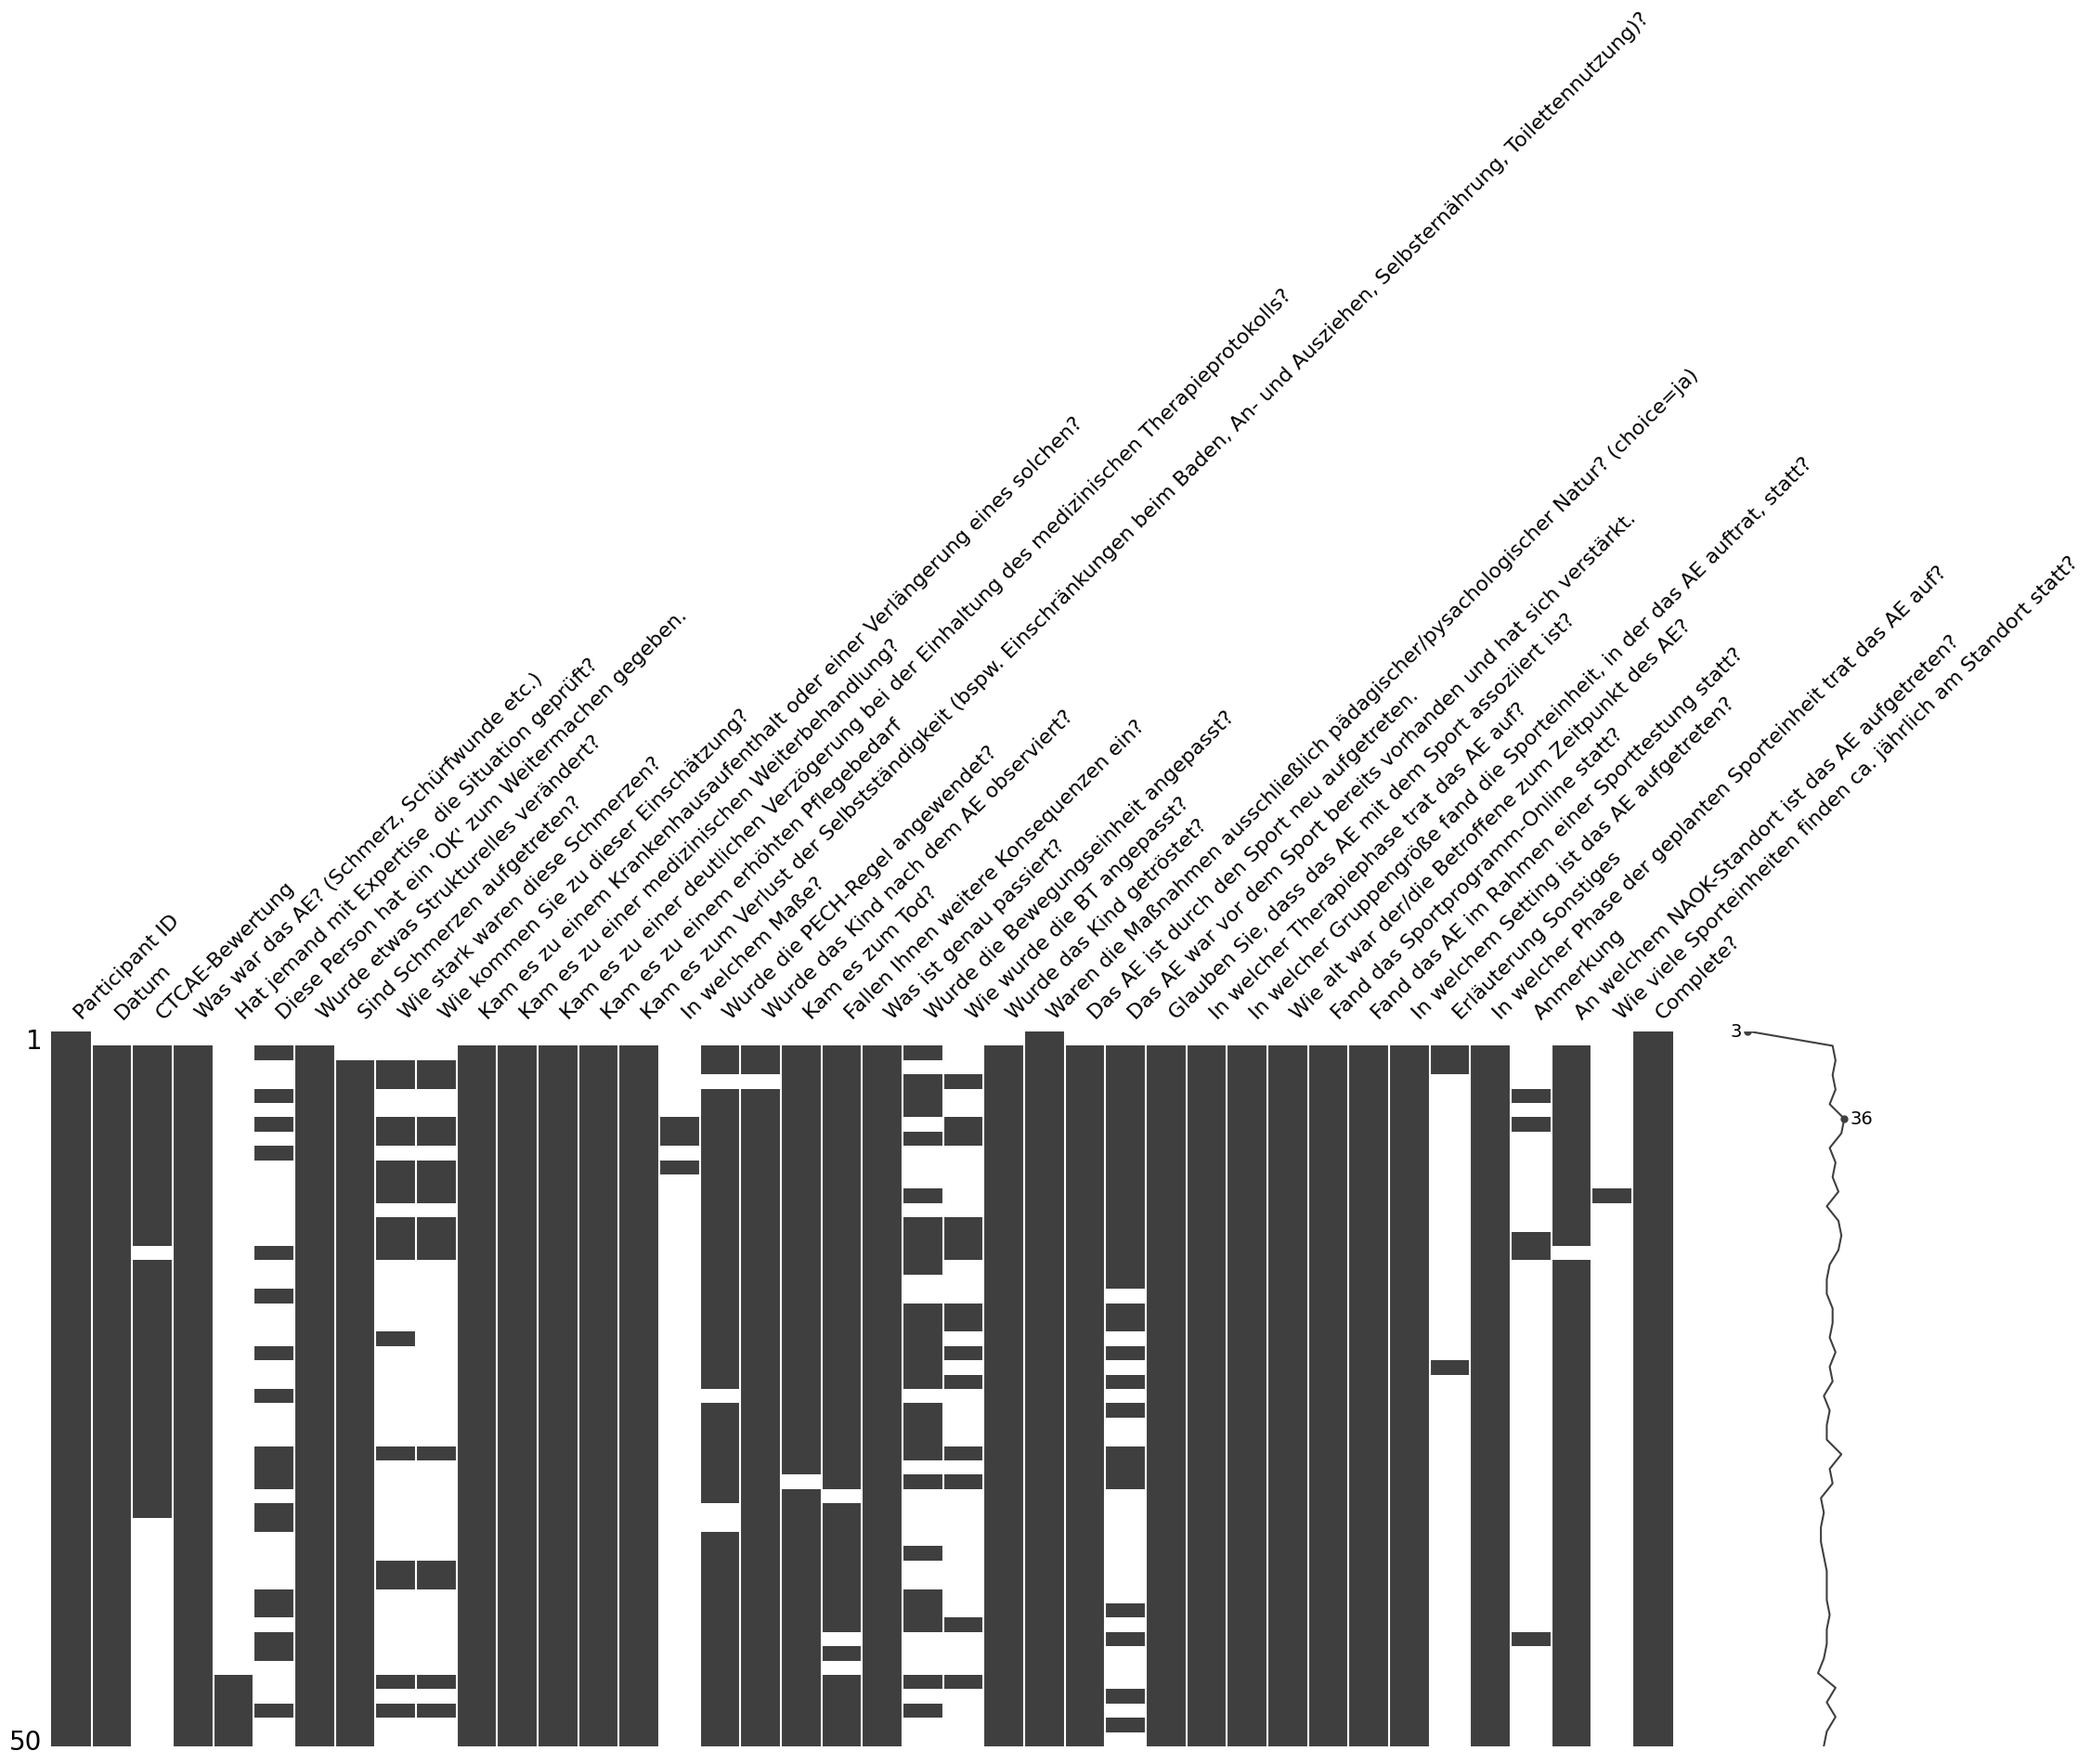

In [147]:
mi.matrix(df_csv)
# mi.bar(df_csv)

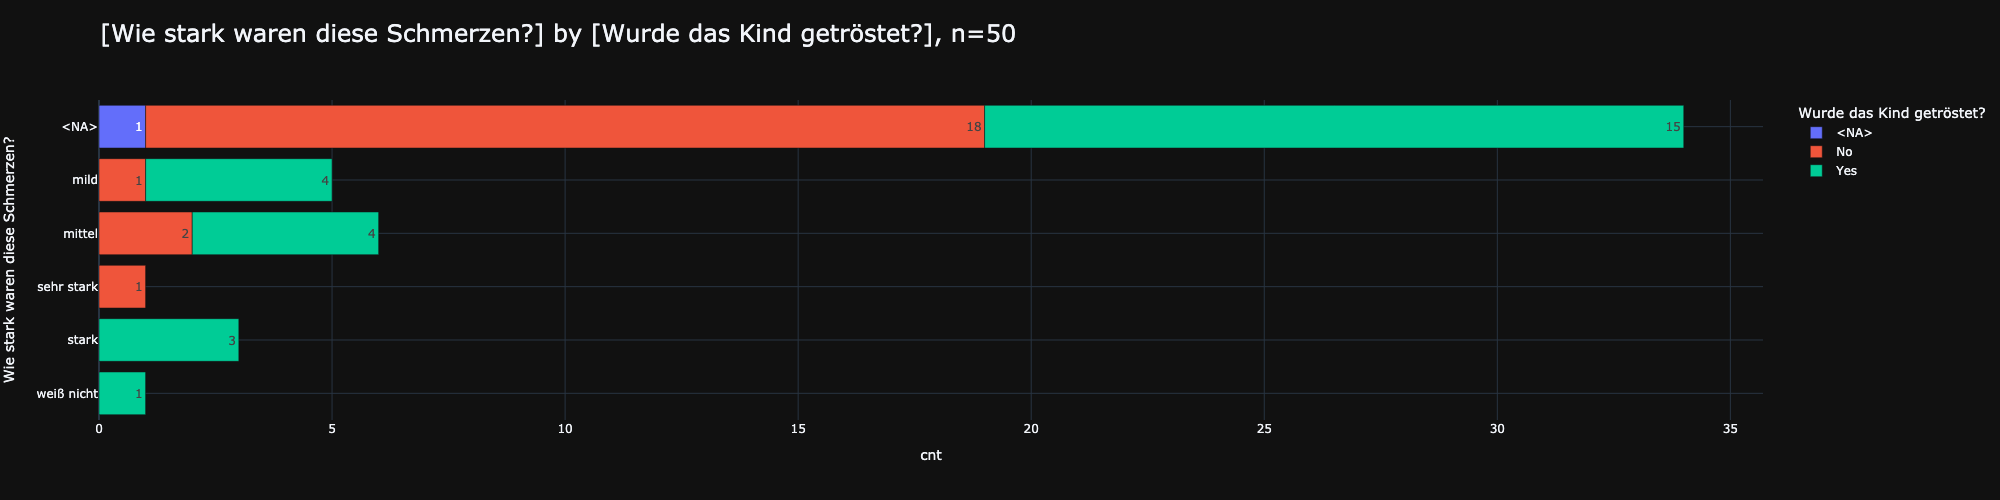

In [148]:
_df=df_csv[['Wurde das Kind getröstet?', 'Wie stark waren diese Schmerzen?']]
pls.plot_stacked_bars(_df, orientation="h", swap=True)